# Grad Cam 

This notebook shows how to produce "visual explanations" using the [grad cam technique](https://arxiv.org/abs/1610.02391). This technique is fairly general, and can be applied to a wide range of CNNs to visually explain their behavior. This is a useful tool for debugging/understanding CNNs.

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install -U --quiet git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

     |████████████████████████████████| 51kB 2.6MB/s 


## Plot utils

In [22]:
def plot_image_prediction(image_path, base_model):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, IMG_SIZE)
  image = efn.preprocess_input(image)
  image = tf.expand_dims(image, axis=0)
  decoded_pred = decode_predictions(base_model(image, training=False).numpy(), top=5)[0]
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  image_rgb = np.clip((image.numpy()*std)+mean,0,1) 
  plt.figure(figsize=(6,6))
  plt.imshow(image_rgb[0,:,:,:])
  plt.show()
  print(decoded_pred)
  return image, image_rgb

## Model

We will use EfficientNet B0 but this technique can be applied to any CNN.

In [21]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=True)
# Freeze the model
base_model.trainable = False
# Set the last layer's activation to None, we want the logits, not the probas
base_model.layers[-1].activation = None

## Grad Cam

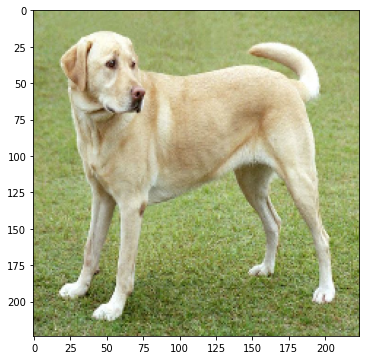

[('n02099712', 'Labrador_retriever', 7.9365997), ('n02099849', 'Chesapeake_Bay_retriever', 5.5225916), ('n02099601', 'golden_retriever', 5.195472), ('n02115641', 'dingo', 4.4783874), ('n02091244', 'Ibizan_hound', 4.418677)]


In [23]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image, image_rgb = plot_image_prediction(image_path, base_model)

In [24]:
def get_grad_cam(image, base_model, layer_name, class_index):
  grad_model = tf.keras.models.Model([base_model.inputs], [base_model.get_layer(layer_name).output, base_model.output])

  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image, training=False)
    predictions = predictions[:, class_index]

  grads = tape.gradient(predictions, conv_outputs)[0]
  conv_outputs = conv_outputs[0]

  gate_o = tf.cast(conv_outputs > 0 , 'float32')
  gate_g = tf.cast(grads > 0 , 'float32')

  grads = gate_o * gate_g * grads # guided gradients 
  conv_outputs = gate_o * conv_outputs # rectified outputs 

  weights = tf.reduce_mean(grads, axis=(0,1))
  cam = conv_outputs @ weights[..., tf.newaxis]

  cam = tf.image.resize(cam, size=(image.shape[1], image.shape[2]))
  cam = cam.numpy()[:,:,0]
  cam = (cam - cam.min()) / (cam.max() - cam.min()) # min max scaling cam
  return cam

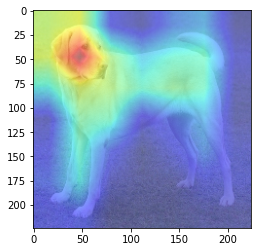

In [25]:
layer_name = 'top_activation'
class_index = 208
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

Good, the grad cam seems to be excited around regions we visually consider as important.

## Let's try another image

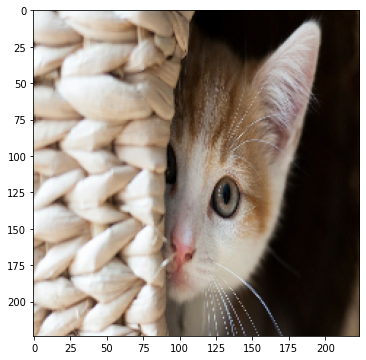

[('n02124075', 'Egyptian_cat', 7.210612), ('n02123597', 'Siamese_cat', 6.9315443), ('n02127052', 'lynx', 5.3514504), ('n02123045', 'tabby', 5.3307066), ('n04590129', 'window_shade', 5.0637617)]


In [26]:
image_path = tf.keras.utils.get_file('Fun_cat2.jpg', 'https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2018/08/kitten-440379.jpg?h=c8d00152&itok=1fdekAh2')
image, image_rgb = plot_image_prediction(image_path, base_model)

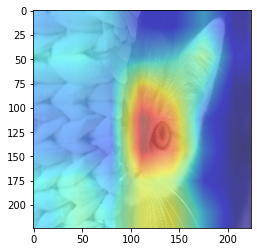

In [27]:
layer_name = 'top_activation'
class_index = 285
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

## Let's try a multi label image.

The following example has two classes represented, let's see how the grad cam behaves in this case.

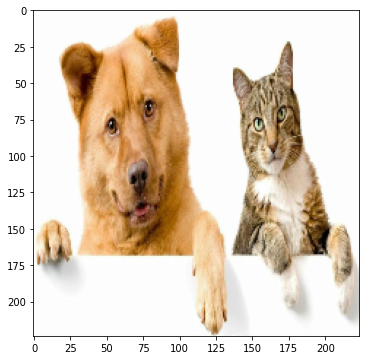

[('n02112137', 'chow', 6.926036), ('n02123045', 'tabby', 6.0038414), ('n02123159', 'tiger_cat', 4.7865763), ('n02124075', 'Egyptian_cat', 4.494739), ('n02129165', 'lion', 4.430103)]


In [28]:
url = 'https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg'
image_path = tf.keras.utils.get_file('cat_and_dog.jpg', url)
image, image_rgb = plot_image_prediction(image_path, base_model)

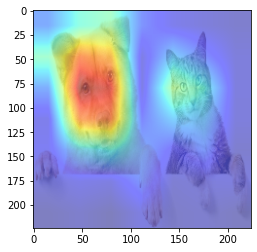

In [29]:
layer_name = 'top_activation'
class_index = 260
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

The chow is highlighted by the grad cam, this is what we expected. A lower amplitude activation is also visible around the cat's face, but much weaker than the one highlighting the chow.

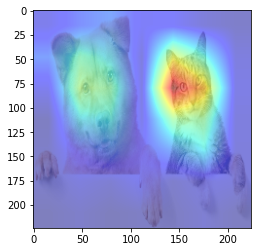

In [30]:
layer_name = 'top_activation'
class_index = 281
cam = get_grad_cam(image, base_model, layer_name, class_index)
plt.imshow(image_rgb[0], alpha=0.5)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.show()

Same comment as above. The grad cam behaves as expected in multilabel settings.

Multilabel images are important to consider, since most media online is multilabel, unless it has been carefully processed or curated.